# Advanced-Lane-Lines
The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.


The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline

## 1) Camera Calibration

In [ ]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#Number of corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images_calib = glob.glob('./camera_cal/*.jpg')

for fname in images_calib:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners2,ret)
        #fig = plt.figure()
        #plt.imshow(img)
        #plt.title('Camera calibration')

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
        
        
calibration_info = { "ret": ret, "mtx": mtx, "dist": dist, "rvecs": rvecs,
"tvecs": tvecs }

pickle.dump( calibration_info, open( "calib_info.p", "wb" ) )


## 2) Distortion correction

In [2]:
# Remove distortion from images
def undistort(img, mtx, dist, show=False):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image')
    
    return undist    

### Example distortion correction on images

In [3]:
# Load calibration info
cal_pickle = pickle.load( open("calib_info.p", "rb" ) )
mtx_l = cal_pickle["mtx"]
dist_l = cal_pickle["dist"]



In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    img = cv2.imread(fname)
    undistort(img,mtx_l, dist_l, show=True)
    

# Define Mask to detect lines

In [4]:
# Masks the image based on gradient absolute value.
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


# Masks the image based on gradient magnitude.
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Masks the image based on gradient direction.
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

def color_threshold_hls(image, s_thresh=(100,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(s_binary)
    #plt.title('hls')
    
    return s_binary



def color_treshold_lab(image, b_thresh, l_thresh):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b_channel = lab[:,:,2]
    l_channel = lab[:,:,0]
               
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <=  l_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(l_binary)
    #plt.title('lab-l')
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh[0]) & (b_channel <=  b_thresh[1])] = 1
    #plt.figure()
    #plt.imshow(b_binary)
    #plt.title('lab-b')    
    combined_binary = np.zeros_like(b_channel)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    #plt.figure()
    #plt.imshow(b_binary)
    #plt.title('lab')

    return combined_binary

def get_mask(image, ksize=3, show = False):
    

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    image_blur = cv2.GaussianBlur(image, (5, 5), 0)
    gradx = abs_sobel_thresh(image_blur, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    #grady = abs_sobel_thresh(image_blur, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(image_blur, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image_blur, sobel_kernel=ksize, thresh=(0.8, 1.2))
    
    g_combined = np.zeros_like(dir_binary)
    #g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    g_combined[(gradx == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
    kernel = np.ones((5,5),np.uint8)
    g_combined = cv2.morphologyEx(g_combined, cv2.MORPH_OPEN, kernel)
    
    color_binary_hsl = color_threshold_hls(image, s_thresh=(200,255))
    color_binary_lab = color_treshold_lab(image, b_thresh=(155,200), l_thresh=(230,255))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(color_binary_hsl == 1) | (color_binary_lab == 1)] = 1
    
        
    all_combined = np.zeros_like(image[:,:,0])
    #g_combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    all_combined[(g_combined == 1)  | (combined_binary == 1) ] = 1

    
    return all_combined, color_binary_lab



# Test the masks

In [ ]:
#image = mpimg.imread('test_images/test1.jpg')

images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    result_g, result_c = get_mask(image, ksize=5 )

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_g)
    ax2.set_title('All', fontsize=18)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result_c)
    ax2.set_title('Color segmentation', fontsize=18)




# Perspective Transform

In [6]:
def perspective_transform(gray, mtx_l, dist_l):

    # Convert undistorted image to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])
    (h, w) = (gray.shape[0], gray.shape[1])
    # Define source points and destination 
    src = np.float32([[w // 2 - 76, h * .625], [w // 2 + 76, h * .625], [-100, h], [w + 100, h]])
    dst = np.float32([[100, 0], [w - 100, 0], [100, h], [w - 100, h]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(gray, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv


In [ ]:
images_list = glob.glob('./test_images/*.jpg')

for fname in images_list:
  
    image = mpimg.imread(fname)
    image = undistort(image, mtx_l, dist_l, show=False)
    
    result_g, result_c = get_mask(image)
    
    result,M,Minv = perspective_transform(result_g, mtx_l, dist_l)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    ax1.axis('off')
    ax1.imshow(image)
    ax1.set_title('Original', fontsize=18)
    ax2.axis('off')
    ax2.imshow(result)
    ax2.set_title('Perspective Transform', fontsize=18)
    #plt.figure()
    #histogram = np.sum(result[result.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)



## Line Finding Method: Peaks in a Histogram

In [16]:
def find_lanes(binary_warped, nwindows = 9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    #plt.figure()

    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    return out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty 


def draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

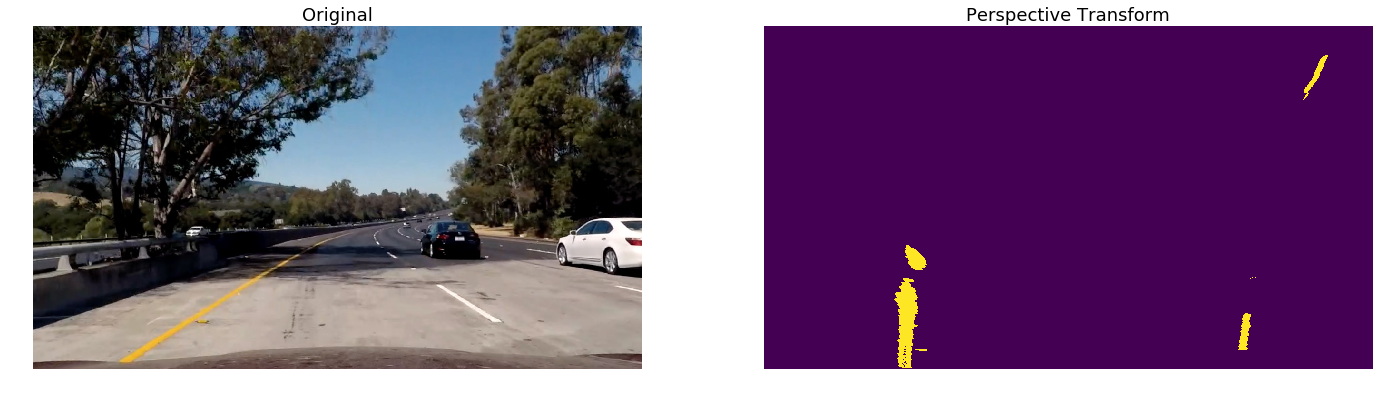

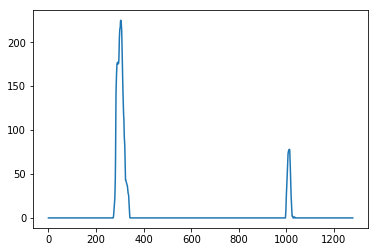

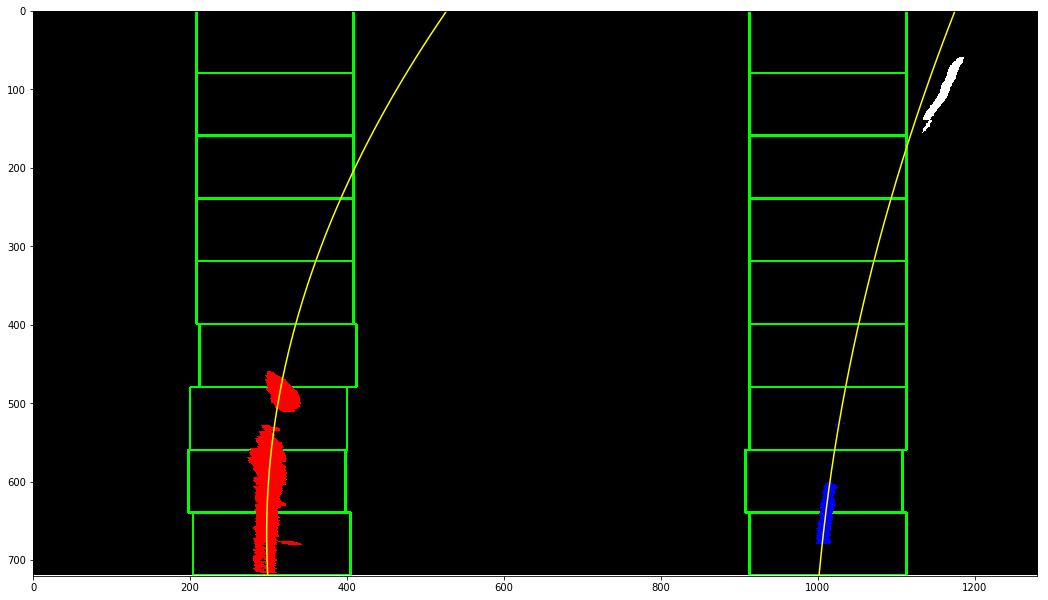

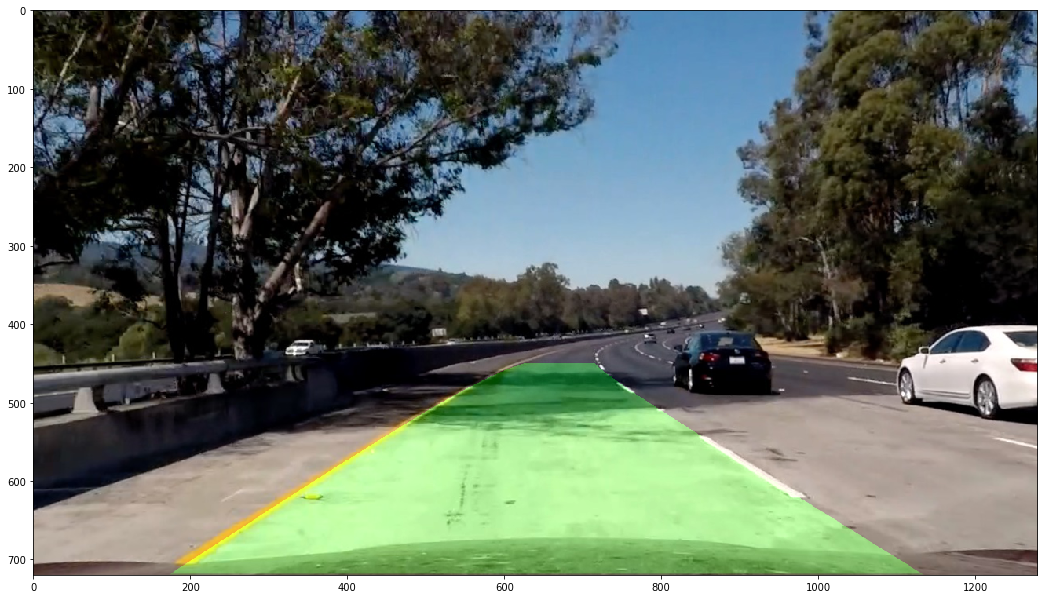

In [8]:
image = mpimg.imread("test_images/test5.jpg")
image = undistort(image, mtx_l, dist_l, show=False)
result_g, result_c = get_mask(image)

binary_warped, M, Minv = perspective_transform(result_c, mtx_l, dist_l)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
ax1.axis('off')
ax1.imshow(image)
ax1.set_title('Original', fontsize=18)
ax2.axis('off')
ax2.imshow(binary_warped)
ax2.set_title('Perspective Transform', fontsize=18)

# Find lanes
out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)

# Plot Result
plt.figure(figsize=(18,18))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv )


plt.figure(figsize=(18,18))
plt.imshow(result)

# Test on Video

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [41]:
def process_image(image):
    
    image = undistort(image, mtx_l, dist_l, show=False)
    result_g, result_c = get_mask(image)

    binary_warped, M, Minv = perspective_transform(result_c, mtx_l, dist_l)

    # Find lanes
    out_img, left_fitx, right_fitx, leftx, lefty, rightx, righty, ploty  = find_lanes(binary_warped)
    # Draw lines
    result = draw_lines(image, binary_warped, left_fitx, right_fitx, ploty, Minv)
    
    out_img_small = cv2.resize(out_img, (int(out_img.shape[1]/3),int(out_img.shape[0]/3)))
    
    x_offset=20
    y_offset=20
    result[y_offset:y_offset+out_img_small.shape[0], x_offset:x_offset+out_img_small.shape[1]] = out_img_small

    return result

In [19]:
print(out_img.shape)

(720, 1280, 3)


In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output_grad.mp4'
clip2 = VideoFileClip('project_video.mp4')
output_clip = clip2.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output_grad.mp4
[MoviePy] Writing video project_video_output_grad.mp4


100%|█████████▉| 1260/1261 [04:16<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_grad.mp4 

CPU times: user 8min 9s, sys: 38 s, total: 8min 47s
Wall time: 4min 17s


In [34]:

from IPython.display import HTML
video_output = 'videos/project_video_out1.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

videos/project_video_out1.mp4
